In [50]:
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch
import math

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [62]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


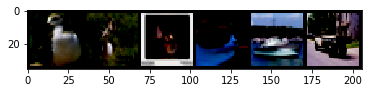

 bird  deer   cat   cat


In [24]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [71]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def densenet_cifar():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)

In [72]:
DenseNet = densenet_cifar()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(DenseNet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [ ]:
import torch.optim as optim

total_step = len(trainloader)
losses = []
acc_list = []
for epoch in range(2):
    
    running_loss = 0.0
    
    for i , data in enumerate(trainloader,0):
        
        inputs, labels = data
        outputs = DenseNet(inputs)
        
        #Calculate Loss 
        loss = criterion(outputs,labels)
        losses.append(loss)
        
        #Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, 2, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
print('Finished Training')

Epoch [1/2], Step [10/500], Loss: 2.1070, Accuracy: 14.00%
Epoch [1/2], Step [20/500], Loss: 2.1274, Accuracy: 23.00%
Epoch [1/2], Step [30/500], Loss: 1.7434, Accuracy: 36.00%
Epoch [1/2], Step [40/500], Loss: 2.0313, Accuracy: 24.00%
Epoch [1/2], Step [50/500], Loss: 1.9526, Accuracy: 29.00%
Epoch [1/2], Step [60/500], Loss: 1.9294, Accuracy: 36.00%
Epoch [1/2], Step [70/500], Loss: 1.7054, Accuracy: 39.00%
Epoch [1/2], Step [80/500], Loss: 1.7703, Accuracy: 32.00%
Epoch [1/2], Step [90/500], Loss: 1.7632, Accuracy: 40.00%
Epoch [1/2], Step [100/500], Loss: 1.6912, Accuracy: 41.00%
Epoch [1/2], Step [110/500], Loss: 1.6106, Accuracy: 42.00%
Epoch [1/2], Step [120/500], Loss: 1.6139, Accuracy: 43.00%
Epoch [1/2], Step [130/500], Loss: 1.6899, Accuracy: 39.00%
Epoch [1/2], Step [140/500], Loss: 1.6737, Accuracy: 39.00%
Epoch [1/2], Step [150/500], Loss: 1.5575, Accuracy: 44.00%
Epoch [1/2], Step [160/500], Loss: 1.6138, Accuracy: 39.00%
Epoch [1/2], Step [170/500], Loss: 1.3981, Accura

Reference : https://github.com/kuangliu/pytorch-cifar/blob/master/models/densenet.py